In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI, FMRI_SURFACE_LEVEL_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, IDS_IMAGES_TEST, IDS_IMAGES_IMAGERY, IMAGERY_SCENES
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, \
ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, Normalize, IMAGE, CAPTION, get_distance_matrix, \
ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, calc_all_pairwise_accuracy_scores, get_nn_latent_data, get_fmri_data_paths

from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, PALETTE_BLACK_ONLY, METRICS_IMAGERY, get_data_default_feats

MODELS = ["clip", "imagebind", "flava", "blip2", "gpt2-large", "gpt2-xl", "dino-large", "dino-giant", "bridgetower", "vilt", "visualbert"]


In [2]:
all_data = load_results_data(MODELS, metrics=METRICS_IMAGERY, recompute_acc_scores=False)

data_whole_brain = all_data.copy()

data_whole_brain = data_whole_brain[data_whole_brain["mask"] == "whole_brain"]
data_whole_brain = data_whole_brain[data_whole_brain.surface == False]

100%|██████████| 468/468 [00:00<00:00, 698.79it/s]


### Model performance ranking

In [3]:
def print_performance_ranking(data):
    data_default_feats = get_data_default_feats(data)
    
    print("imagery")
    dp = data_default_feats.copy()
    dp = dp[dp.training_mode == 'modality-agnostic']
    dp = dp[dp.metric == ACC_IMAGERY]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    print(scores)
    
    print("imagery whole test set")
    dp = data_default_feats.copy()
    dp = dp[dp.training_mode == 'modality-agnostic']
    
    dp = dp[dp.metric == ACC_IMAGERY_WHOLE_TEST]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    print(scores)
    
print_performance_ranking(data_whole_brain)

imagery
model
visualbert     0.777778
flava          0.833333
gpt2-xl        0.833333
dino-giant     0.861111
blip2          0.861111
clip           0.861111
gpt2-large     0.888889
vilt           0.888889
bridgetower    0.888889
dino-large     0.888889
imagebind      0.916667
Name: value, dtype: object
imagery whole test set
model
visualbert     0.661189
gpt2-xl        0.711659
blip2           0.71518
gpt2-large     0.729656
dino-giant     0.732786
clip           0.739437
flava          0.754695
bridgetower    0.759781
vilt           0.762911
dino-large     0.780908
imagebind      0.803208
Name: value, dtype: object


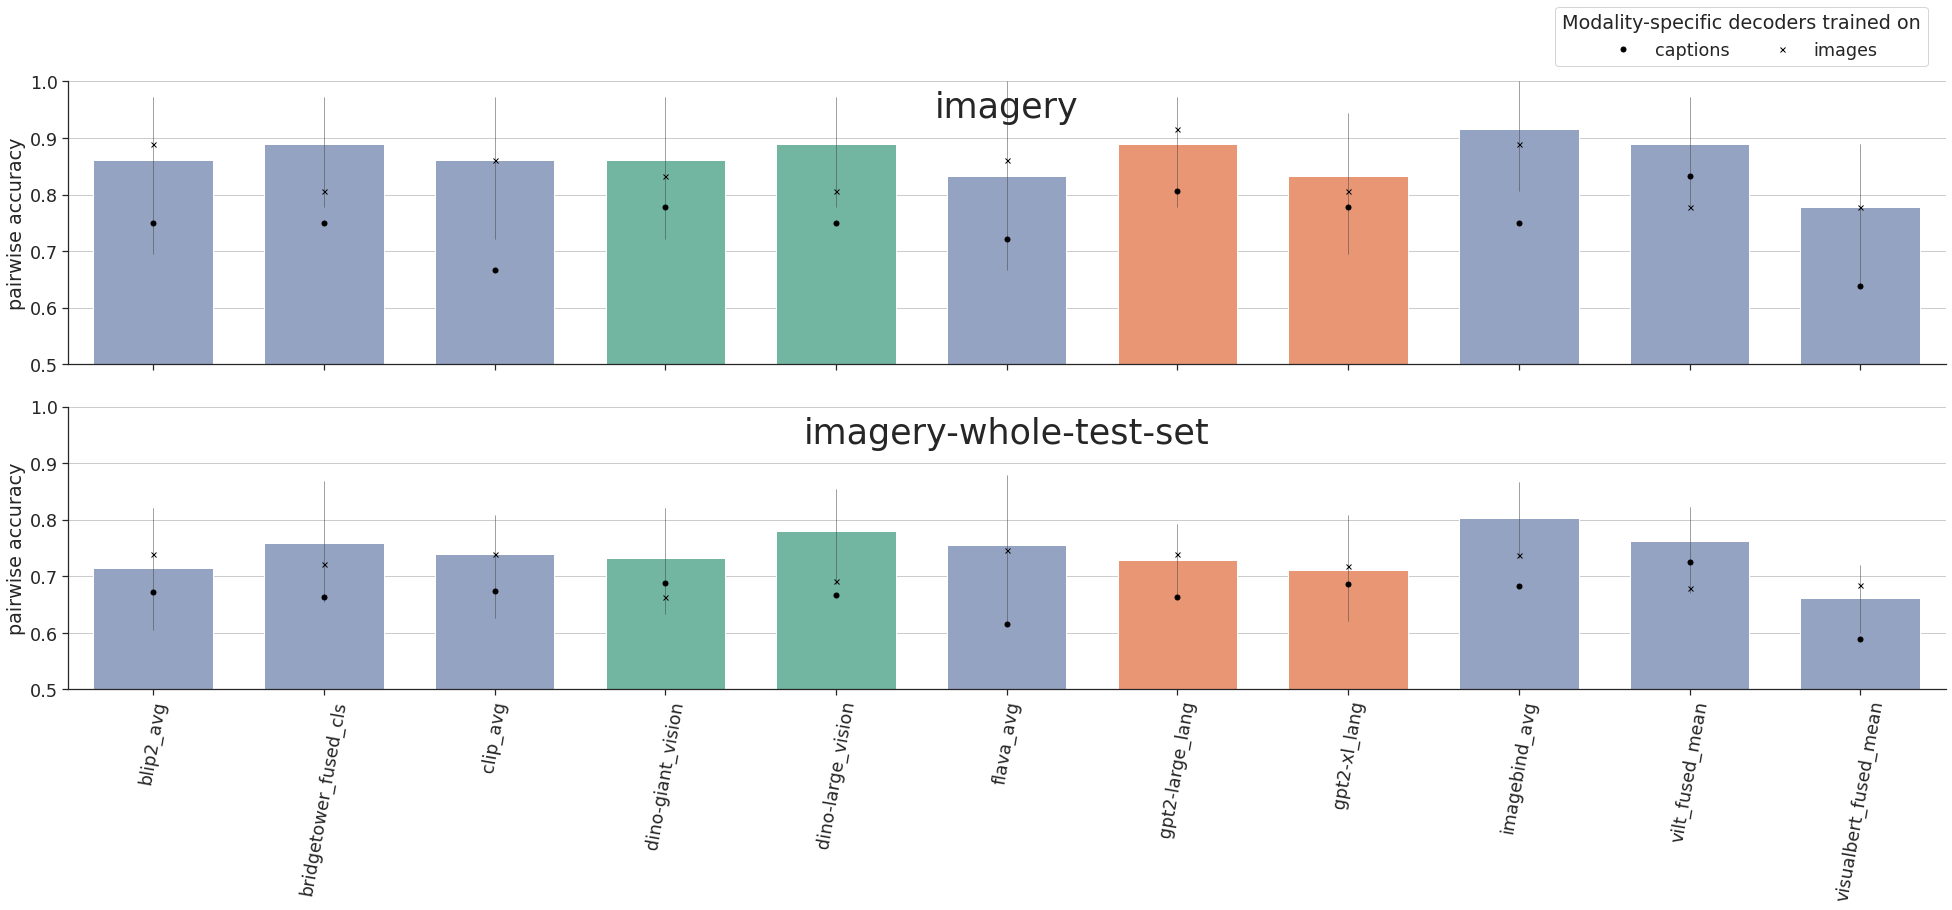

In [4]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

data_to_plot = data_whole_brain.copy()

# data_to_plot = data_to_plot[data_to_plot.features != "matched"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = data_to_plot.model_feat.unique()
metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,1.06), height=6, legend_title="Modality-agnostic decoders projecting into feature space of", plot_legend=False, verify_num_datapoints=False, shorten_label_texts=False)

# plt.savefig(os.path.join(RESULTS_DIR, f"imagery_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# Imagery decoding with normalization based on test set predicions

In [5]:
all_data_alt_norm = load_results_data(MODELS, metrics=METRICS_IMAGERY, recompute_acc_scores=True, norm_imagery_preds_with_test_preds=True)


100%|██████████| 468/468 [00:09<00:00, 48.71it/s]


imagery
model
visualbert     0.777778
flava          0.833333
gpt2-xl        0.833333
dino-giant     0.861111
blip2          0.861111
clip           0.861111
gpt2-large     0.888889
vilt           0.888889
bridgetower    0.888889
dino-large     0.888889
imagebind      0.916667
Name: value, dtype: object
imagery whole test set
model
visualbert     0.490219
flava          0.554382
blip2          0.621283
bridgetower    0.653756
imagebind       0.65493
vilt           0.657277
dino-giant     0.679577
gpt2-xl        0.691315
gpt2-large     0.701487
dino-large     0.703443
clip           0.723787
Name: value, dtype: object


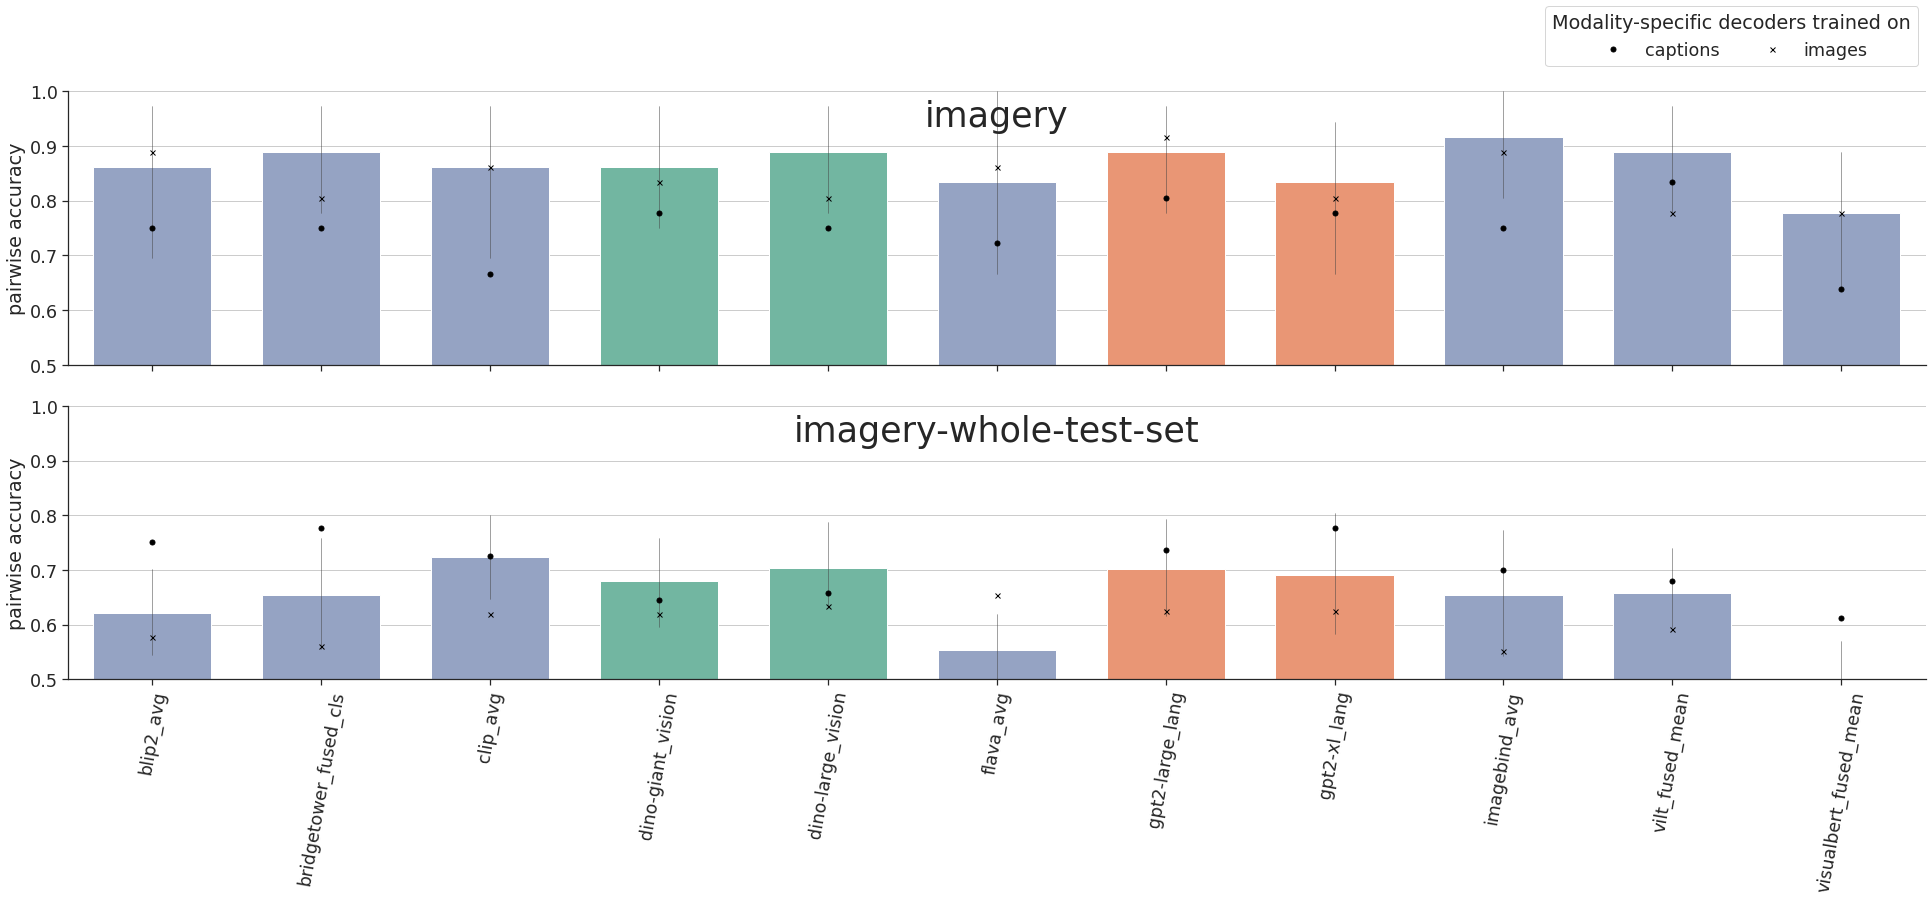

In [6]:
data_whole_brain_alt_norm = all_data_alt_norm.copy()

data_whole_brain_alt_norm = data_whole_brain_alt_norm[data_whole_brain_alt_norm["mask"] == "whole_brain"]
data_whole_brain_alt_norm = data_whole_brain_alt_norm[data_whole_brain_alt_norm.surface == False]

print_performance_ranking(data_whole_brain_alt_norm)

sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

data_to_plot = data_whole_brain_alt_norm.copy()

# data_to_plot = data_to_plot[data_to_plot.features != "matched"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = data_to_plot.model_feat.unique()
metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,1.06), height=6, legend_title="Modality-agnostic decoders projecting into feature space of", plot_legend=False, verify_num_datapoints=False, shorten_label_texts=False)


# Imagery decoding with mask

In [7]:
FEAT_ORDER = ["vision", "lang", "vision+lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')
PALETTE_BLACK_ONLY = [(0, 0, 0)] * 10


def create_result_graph_cluster_comparisons(data, x_variable="model_feat", order=None, metrics=["pairwise_acc_captions", "pairwise_acc_images"],
                        hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Legend", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None,
                        row_variable="metric", row_order=None, col_variable=None, legend_bbox=(0.06, 0.97),
                        legend_2_bbox=(0.99, 0.97), height=4.5, row_title_height=0.85, aspect=4,
                        verify_num_datapoints=True):

    for x_variable_value in order:
        length = len(data[(data[x_variable] == x_variable_value) & (data.metric == metrics[0])])
        # print(data[(data[x_variable] == x_variable_value) & (data.metric == metrics[0]) & (data.subject == SUBJECTS[0])])
        expected_num_datapoints = len(SUBJECTS)
        if hue_variable != "features":
            expected_num_datapoints *= len(data[hue_variable].unique())
        if (length > 0) and (length != expected_num_datapoints):
            message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) ({x_variable}: {x_variable_value}"
            if verify_num_datapoints:
                raise RuntimeError(message)
            else:
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data, order=order, metrics=metrics,
                                                       x_variable=x_variable, legend_title=legend_title,
                                                       legend_bbox=legend_bbox, height=height, aspect=aspect,
                                                       hue_variable=hue_variable, row_variable=row_variable,
                                                       row_order=row_order, col_variable=col_variable,
                                                       hue_order=hue_order, palette=palette, ylim=ylim,
                                                       noise_ceilings=noise_ceilings, shorten_label_texts=False, plot_legend=True)

    for m, metric in enumerate(metrics):
        catplot_g.axes[m, 0].set_title(metrics[m].replace("pairwise_acc_", "").replace("_", "-"), fontsize=35,
                                       y=row_title_height)
        catplot_g.axes[m, 0].set_ylabel('pairwise accuracy')

    plt.subplots_adjust(hspace=0.15)
    return catplot_g, lgd


In [8]:
# MODELS = ["clip", "imagebind", "flava", "blip2", "gpt2-large", "gpt2-xl", "dino-large", "dino-giant", "lxmert", "bridgetower", "vilt", "visualbert"]
MODELS = ["imagebind", "blip2"]

def imagery_decoding_masks_plot(training_mode):
    data_to_plot = all_data[all_data.model.isin(MODELS)].copy()
    data_to_plot = data_to_plot[data_to_plot.training_mode == training_mode]
    resolution = "fsaverage7"
    data_to_plot = data_to_plot[(data_to_plot.resolution == resolution) | (data_to_plot["mask"] == "whole_brain")]
    data_to_plot = data_to_plot[(data_to_plot.surface == True) & (data_to_plot["mask"] != "whole_brain") | (data_to_plot.surface == False) & (data_to_plot["mask"] == "whole_brain")]

    data_to_plot = data_to_plot[data_to_plot.features != "matched"]
    
    include_masks = [mask_name for mask_name in data_to_plot["mask"].unique() if not "masks_400" in mask_name and "imagebind" in mask_name]  # "thresh_0.0001" in mask_name and 
    include_masks += ["whole_brain"]
    data_to_plot = data_to_plot[data_to_plot["mask"].isin(include_masks)]
    print(data_to_plot["mask"].unique())
    
    metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
    masks_order = data_to_plot["mask"].unique()
    models_order = data_to_plot.model_feat.unique()
    figure, lgd = create_result_graph_cluster_comparisons(data_to_plot, x_variable="model_feat", order=models_order, metrics=metrics_order, row_order=metrics_order, hue_variable="mask", hue_order=masks_order, ylim=(0.5, 1), row_title_height=0.85,
                                 legend_bbox=(0.7,1.15), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Mask", verify_num_datapoints=False)
    
    figure.fig.suptitle(f"training mode: {training_mode}", y=1.03, fontsize=40)
    return data_to_plot

['whole_brain']
['whole_brain']
['whole_brain']


,,,mean_val,count
model,features,mask,,
imagebind,avg,whole_brain,0.803208,6


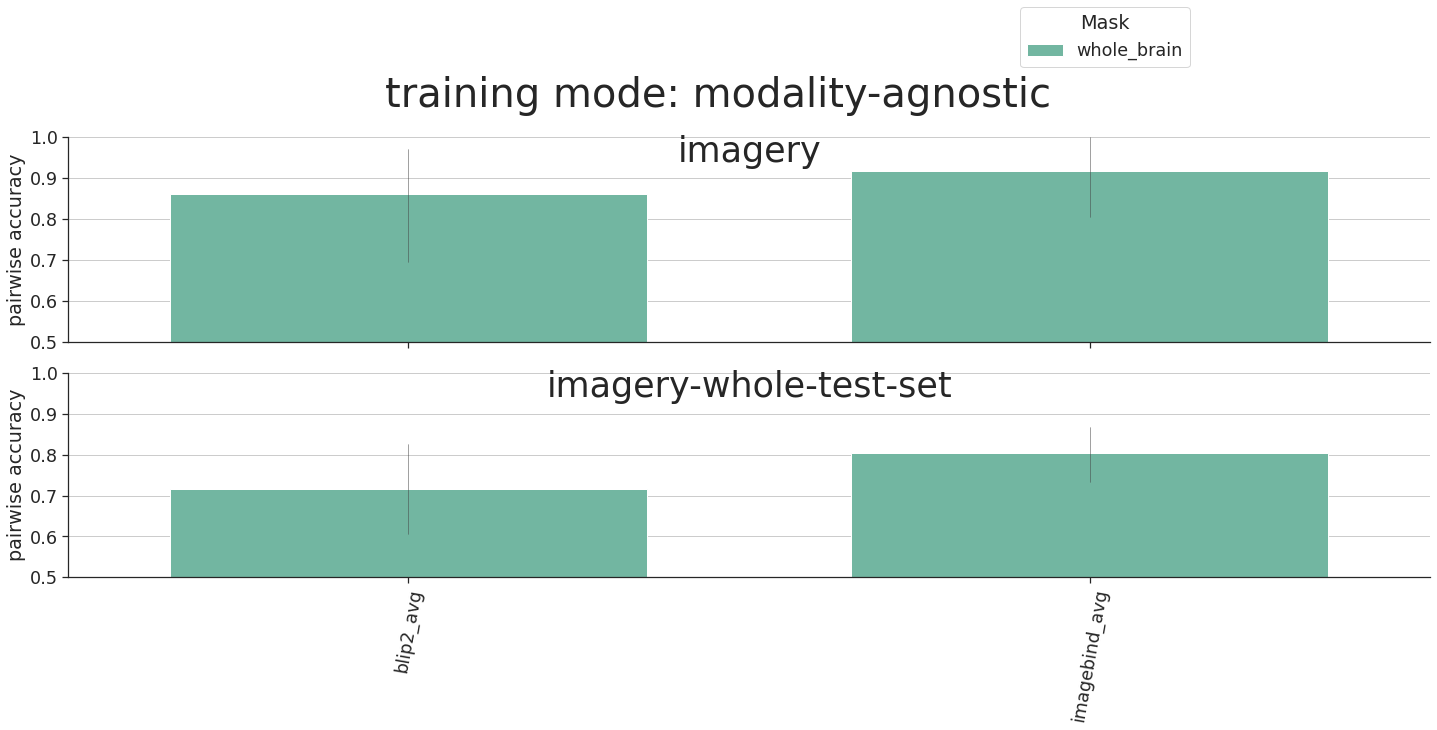

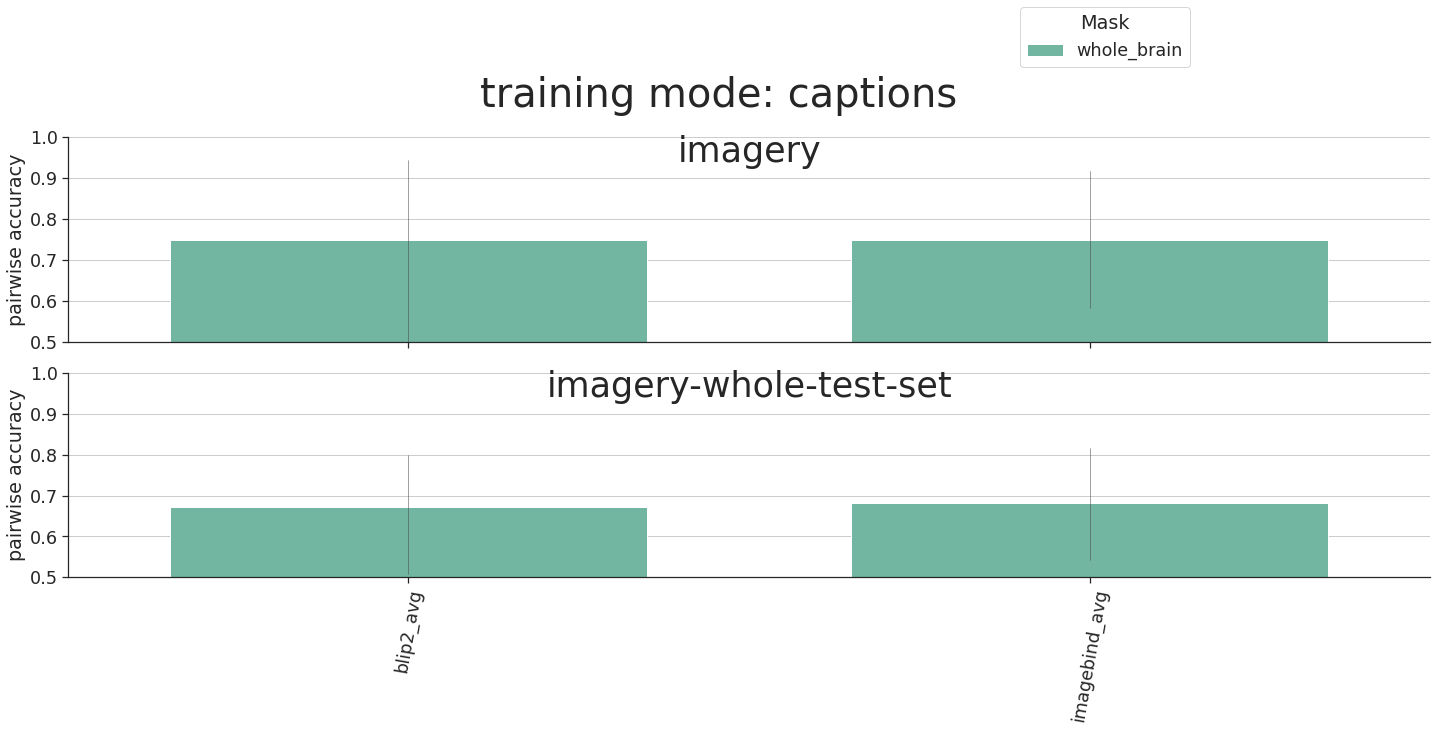

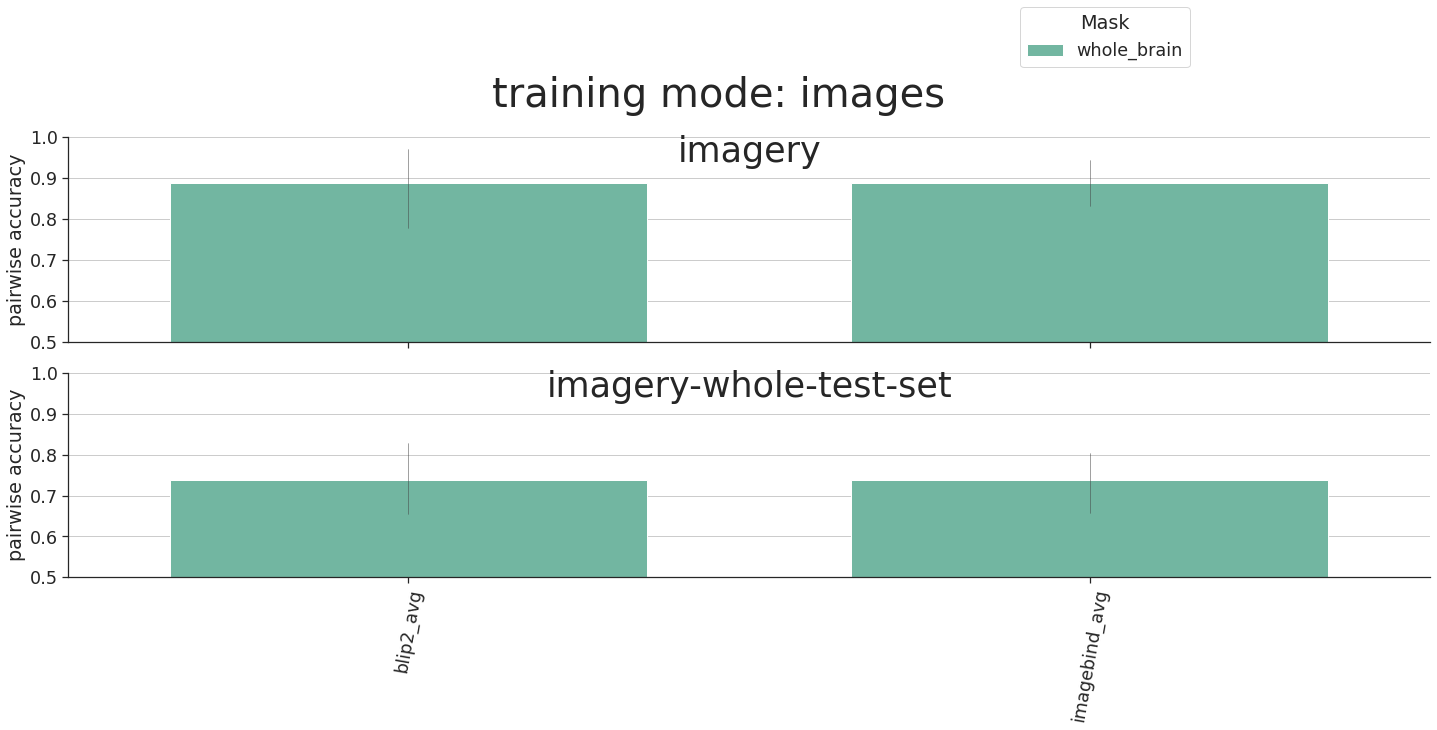

In [9]:
result = imagery_decoding_masks_plot("modality-agnostic")
imagery_decoding_masks_plot("captions")
imagery_decoding_masks_plot("images")

# result = result[result.model_feat == "blip2_avg"]
result = result[result.model_feat == "imagebind_avg"]

result[(result.metric == ACC_IMAGERY_WHOLE_TEST)].groupby(["model", "features", "mask"]).agg(mean_val=('value', 'mean'), count=('value', 'count')) # subject

Series([], Name: num_voxels, dtype: float64)


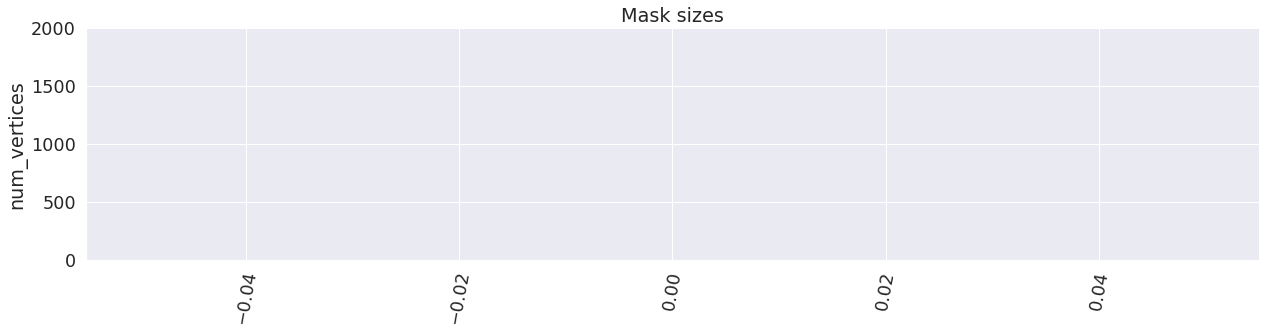

In [10]:
def create_mask_sizes_plot(data, x_variable, ylim=(0.5, 1), y_variable="value", ylabel="pairwise_acc", row_variable="metric", hue_variable="condition", title=None):
    sns.set(font_scale=1.6)
    TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
    FEAT_ORDER = ["vision models", "language models", "multimodal models"]
    
    data_to_plot = data.copy()
    
    data_to_plot = data_to_plot[data_to_plot.training_mode == "modality-agnostic"]
        
    height = 4.5
    aspect = 4
   
    g = sns.catplot(data_to_plot, kind="bar", x=x_variable, y=y_variable, row=row_variable, row_order=None, col=None, height=height, aspect=aspect, hue=hue_variable, hue_order=None,
                    palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)

    g.set(ylim=ylim, ylabel=ylabel, xlabel='')
    g.tick_params(axis='x', rotation=80)
    if title:
        g.fig.suptitle(title, y=1.03)
    return data_to_plot
    
data_plotted = result[result["mask"] != "whole_brain"]
create_mask_sizes_plot(data_plotted, x_variable="mask", y_variable="num_voxels", ylim=(0, 2000), ylabel="num_vertices", row_variable=None, hue_variable=None)
_ = plt.title("Mask sizes")

print(data_plotted[(data_plotted.metric == ACC_IMAGERY_WHOLE_TEST)].groupby(["mask"])['num_voxels'].mean())


# Nearest Neighbors of imagined pictures

In [11]:
all_data_alt_norm

,alpha,model,subject,features,test_features,vision_features,lang_features,training_mode,mask,num_voxels,surface,resolution,metric,value,model_feat
0,100000.0,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,modality-agnostic,whole_brain,132633,False,fsaverage,predictions,"[[0.0027029165, -0.0048443377, 0.00518466, -0....",blip2_avg
1,100000.0,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,modality-agnostic,whole_brain,132633,False,fsaverage,latents,"[[-0.44574347, 0.251538, -1.1261009, -0.491602...",blip2_avg
2,100000.0,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,modality-agnostic,whole_brain,132633,False,fsaverage,stimulus_ids,"[3862, 6450, 16764, 25902, 38938, 43966, 47566...",blip2_avg
3,100000.0,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,modality-agnostic,whole_brain,132633,False,fsaverage,stimulus_types,"[caption, caption, caption, caption, caption, ...",blip2_avg
4,100000.0,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,modality-agnostic,whole_brain,132633,False,fsaverage,pairwise_acc_imagery,0.833333,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,100000.0,visualbert,sub-07,fused_mean,fused_mean,n_a,n_a,images,whole_brain,123559,False,fsaverage,pairwise_acc_imagery,0.833333,visualbert_fused_mean
1778,100000.0,visualbert,sub-07,fused_mean,fused_mean,n_a,n_a,images,whole_brain,123559,False,fsaverage,pairwise_acc_imagery_whole_test_set,0.2723,visualbert_fused_mean
1779,100000.0,visualbert,sub-07,fused_mean,fused_mean,n_a,n_a,images,whole_brain,123559,False,fsaverage,imagery_predictions,"[[-0.08101822, 0.1221614, 0.18311065, 0.059283...",visualbert_fused_mean
1780,100000.0,visualbert,sub-07,fused_mean,fused_mean,n_a,n_a,images,whole_brain,123559,False,fsaverage,imagery_latents,"[[-1.0449657, -0.25831068, 0.3754263, 0.265032...",visualbert_fused_mean


In [12]:
MODEL = "imagebind"
data_default_feats = get_data_default_feats(data_whole_brain)

df_model = data_default_feats[data_default_feats.model == MODEL]

train_latents = dict()
train_stim_ids = dict()
for subject in SUBJECTS:
    assert len(df_model.vision_features.unique()) == 1
    features = df_model.features.values[0]
    # print(features)
    vision_features = df_model.vision_features.values[0]
    # print(vision_features)
    lang_features = df_model.lang_features.values[0]
    # print(lang_features)
    _, stim_ids, stim_types = get_fmri_data_paths(subject, "train")
    train_stim_ids[subject] = stim_ids
    train_stim_types = ["image"] * len(train_stim_ids[subject])
    train_latents[subject], _ = get_nn_latent_data(
                                        MODEL, features,
                                        vision_features,
                                        lang_features,
                                        train_stim_ids[subject],
                                        stim_types,
                                        subject,
                                        "train"
                                    )

In [13]:
from utils import COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH
from feature_extraction.feat_extraction_utils import CoCoDataset
from PIL import Image

coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH, 'image')

In [14]:
MAX_HEIGHT = 500

def display_stimuli(coco_ids):
    print(coco_ids)
    imgs = [np.array(coco_ds.get_img_by_coco_id(img_id)) for img_id in coco_ids]
    # min_height = np.min([np.array(im).shape[0] for im in imgs])
    imgs = [np.vstack((img, np.repeat(255, max(0, MAX_HEIGHT - img.shape[0]) * img.shape[1]* img.shape[2]).reshape((max(0, MAX_HEIGHT - img.shape[0]), img.shape[1], img.shape[2])).astype(img.dtype)))[:MAX_HEIGHT,:,:] for img in imgs]
    stacked = np.hstack(imgs)
    img = Image.fromarray(stacked)
    display(img)

In [15]:
df = data_to_plot.copy()
df["mask"].unique()

array(['whole_brain'], dtype=object)

In [16]:
train_latents[subject]

array([[ 0.30644667, -2.1138482 ,  0.44301903, ...,  0.52527374,
        -1.0900011 , -0.0713427 ],
       [-1.5492132 , -0.79056174,  0.04735394, ...,  1.3407555 ,
        -0.42954412,  1.5123211 ],
       [-0.51914537, -1.3053348 ,  1.9722929 , ...,  1.3636934 ,
         1.0451379 , -0.72827774],
       ...,
       [ 1.5125793 ,  0.62441427,  0.6096099 , ..., -0.20344596,
        -2.0340817 ,  0.25728944],
       [-1.1865358 , -0.4030971 ,  1.4322406 , ...,  1.152794  ,
         0.5265958 ,  0.5413075 ],
       [-0.00820832, -0.2175391 ,  0.2180522 , ..., -0.75947386,
        -0.66080916, -1.4872997 ]], dtype=float32)

In [ ]:
%precision 3

MODEL = "imagebind"
features = "avg"
# features = "lang"

features_candidate_set = "avg"

# lang_features = 'lang_features_mean'
# vision_features = 'vision_features_mean'
lang_features = 'lang_features_cls'
vision_features = 'vision_features_cls'

training_mode = 'modality-agnostic'
# training_mode = 'images'

resolution = "fsaverage7"
# mask = 'masks/thresh_0.01'
mask = 'whole_brain'

df = all_data.copy()

df = df[df.model == MODEL]
df = df[df.training_mode == training_mode]

df = df[df['mask'] == mask]
if mask != "whole_brain":
    df = df[df.resolution == resolution]
    df = df[df.surface == True]
else:
    df = df[df.surface == False]

df = df[df.lang_features == lang_features]
df = df[df.vision_features == vision_features]

df_candidate_set = df[df.features == features_candidate_set].copy()

df = df[df.features == features]

assert len(df[df.metric == "predictions"]) == len(SUBJECTS)

# imagery_preds_all_subjects = []
# for subject in SUBJECTS:
#     df_candidate_set_subj = df_candidate_set[df_candidate_set.subject == subject]
#     imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
#     imagery_preds_all_subjects.append(imagery_predictions)
# imagery_preds_all_subjects = np.concatenate(imagery_preds_all_subjects)
# print(imagery_preds_all_subjects.shape)

all_ranks = []
for subject in SUBJECTS:
    print(subject)
    df_subj = df[df.subject == subject]
    df_candidate_set_subj = df_candidate_set[df_candidate_set.subject == subject]

    # print(df_subj)
    test_predictions = df_subj[df_subj.metric == "predictions"].value.item()
    test_latents = df_candidate_set_subj[df_candidate_set_subj.metric == "latents"].value.item()
    test_stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

    imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
    imagery_latents = df_candidate_set_subj[df_candidate_set_subj.metric == "imagery_latents"].value.item()

    test_latents_image = test_latents[stimulus_types == IMAGE]
    test_latents_caption = test_latents[stimulus_types == CAPTION]

    candidate_set_latents = imagery_latents
    # candidate_set_latents = np.concatenate((imagery_latents, test_latents))
    # candidate_set_latents = np.concatenate((imagery_latents, test_latents_caption))
    # candidate_set_latents = np.concatenate((imagery_latents, train_latents[subject]))

    imagery_stimulus_ids = np.array([i[1] for i in IMAGERY_SCENES[subject]])
    imagery_stimulus_captions = np.array([i[0] for i in IMAGERY_SCENES[subject]])
    
    candidate_set_latents_ids = imagery_stimulus_ids
    # candidate_set_latents_ids = np.concatenate((imagery_stimulus_ids, test_stimulus_ids[:len(test_latents_caption)]))
    # candidate_set_latents_ids = np.concatenate((imagery_stimulus_ids, train_stim_ids[subject]))

    # all_preds = np.concatenate((imagery_predictions, test_predictions))
    preds_normalize = Normalize(imagery_predictions.mean(axis=0), imagery_predictions.std(axis=0)) #TODO
    imagery_predictions = preds_normalize(imagery_predictions)

    dist_mat = get_distance_matrix(imagery_predictions, candidate_set_latents) #, metric="euclidean"
    
    for imagery_stimulus_id, imagery_stimulus_caption, nneighbors_row in zip(imagery_stimulus_ids, imagery_stimulus_captions, dist_mat):
        print(f"imagery stimulus: {imagery_stimulus_caption}")
        # display(coco_ds.get_img_by_coco_id(imagery_stimulus_id))
        target_location = np.argwhere(candidate_set_latents_ids == imagery_stimulus_id)[0][0]
        nneighbors_ids = candidate_set_latents_ids[np.argsort(nneighbors_row)]
        rank = np.argwhere(nneighbors_ids == imagery_stimulus_id)[0][0]
        all_ranks.append(rank)
        display(f"distance to target: {nneighbors_row[target_location]:.3f} | rank: {rank} of {len(nneighbors_row)}")
        display(f"nearest neighbors distances: {np.sort(nneighbors_row)[:10]}")
        display_stimuli(nneighbors_ids[:10])
        print("\n")
    print("\n\n")

print(all_ranks)
print(np.mean(all_ranks))
print(np.mean(all_ranks)/len(nneighbors_row))

# 